# ＪＸ金属 日足

In [6]:
import sys
sys.path.append('..')

import re

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import yfinance as yf

from funcs.technical import psar

In [7]:
pattern = re.compile(r'(.+)\.T')

symbol = '5016.T'
ticker = yf.Ticker(symbol)

df = ticker.history(period='3mo')
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-03-19 00:00:00+09:00,843.0,883.0,842.0,874.0,175980400,0.0,0.0
2025-03-21 00:00:00+09:00,908.0,967.0,905.0,958.0,147470400,0.0,0.0
2025-03-24 00:00:00+09:00,991.0,1040.0,958.0,965.0,111144700,0.0,0.0
2025-03-25 00:00:00+09:00,991.0,991.0,928.0,935.0,52074400,0.0,0.0
2025-03-26 00:00:00+09:00,928.0,966.0,916.0,943.0,40361600,0.0,0.0
2025-03-27 00:00:00+09:00,935.0,946.0,930.0,941.0,5867700,0.0,0.0


## 日足チャートとパラボリック SAR

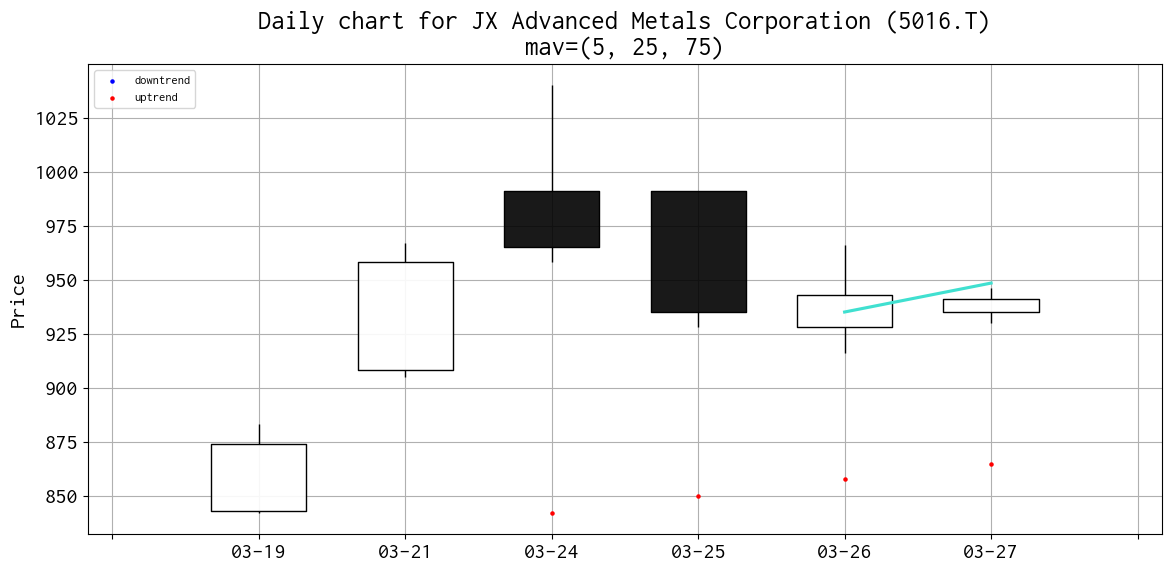

In [8]:
dict_psar = psar(df)

FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams["font.size"] = 16
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)

apds  = [
    mpf.make_addplot(
        dict_psar['bear'],
        type='scatter',
        marker='o',
        markersize=5,
        color='blue',
        label='downtrend',
        ax=ax
    ),
    mpf.make_addplot(
        dict_psar['bull'],
        type='scatter',
        marker='o',
        markersize=5,
        color='red',
        label='uptrend',
        ax=ax
    ),
] 

mpf.plot(
    df,
    type='candle',
    style='default',
    mav=(5, 25, 75),
    volume=False,
    datetime_format='%m-%d',
    addplot=apds,
    xrotation=0,
    ax=ax,
)

try:
    ax.set_title('Daily chart for %s (%s)\nmav=(5, 25, 75)' % (ticker.info['longName'], symbol))
except KeyError:
    ax.set_title('Daily chart for %s\nmav=(5, 25, 75)' % symbol)

ax.grid()
ax.legend(loc='upper left', fontsize=9)

plt.tight_layout()

m = pattern.match(symbol)
if m:
    plt.savefig('daily_chart_%s.png' % m.group(1))
else:
    plt.savefig('daily_chart_%s.png' % symbol)

plt.show()

In [9]:
df.tail(2)['Close']

Date
2025-03-26 00:00:00+09:00    943.0
2025-03-27 00:00:00+09:00    941.0
Name: Close, dtype: float64

In [10]:
df.tail(2)['Close'].diff()

Date
2025-03-26 00:00:00+09:00    NaN
2025-03-27 00:00:00+09:00   -2.0
Name: Close, dtype: float64